In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
df = yf.download("BTC-USD", start="2021-01-01", end="2026-01-06")

[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2021-01-01,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782
...,...,...,...,...,...
2025-12-31,87508.828125,89080.289062,87130.562500,88429.585938,33830210616
2026-01-01,88731.984375,88803.226562,87399.406250,87508.046875,18849043990


In [5]:
df.reset_index(inplace=True)

In [6]:
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df['ema_20'] = df['Close'].ewm(span=20).mean()
df['ema_50'] = df['Close'].ewm(span=50).mean()

df = df[['Close', 'Volume', 'log_return', 'ema_20', 'ema_50']]
df.dropna(inplace=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_7432\1395149985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [7]:
train_size = int(len(df) * 0.85)
train_df = df[:train_size]
test_df = df[train_size:]


In [8]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)


In [9]:
TIME_STEPS = 60
FEATURES = train_scaled.shape[1]

def create_sequences(data):
    X, y = [], []
    for i in range(TIME_STEPS, len(data)):
        X.append(data[i-TIME_STEPS:i])
        y.append(data[i, 2])  # log_return index
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)


In [10]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, FEATURES)),
    Dropout(0.2),

    LSTM(64),
    Dropout(0.2),

    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='huber'
)

model.summary()


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,009 (199.25 KB)

 Trainable params: 51,009 (199.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.0161 - val_loss: 0.0033
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.

In [12]:
pred_returns = model.predict(X_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step


In [13]:
last_close_prices = test_df['Close'].values[TIME_STEPS:]

pred_prices = last_close_prices * np.exp(pred_returns.flatten())


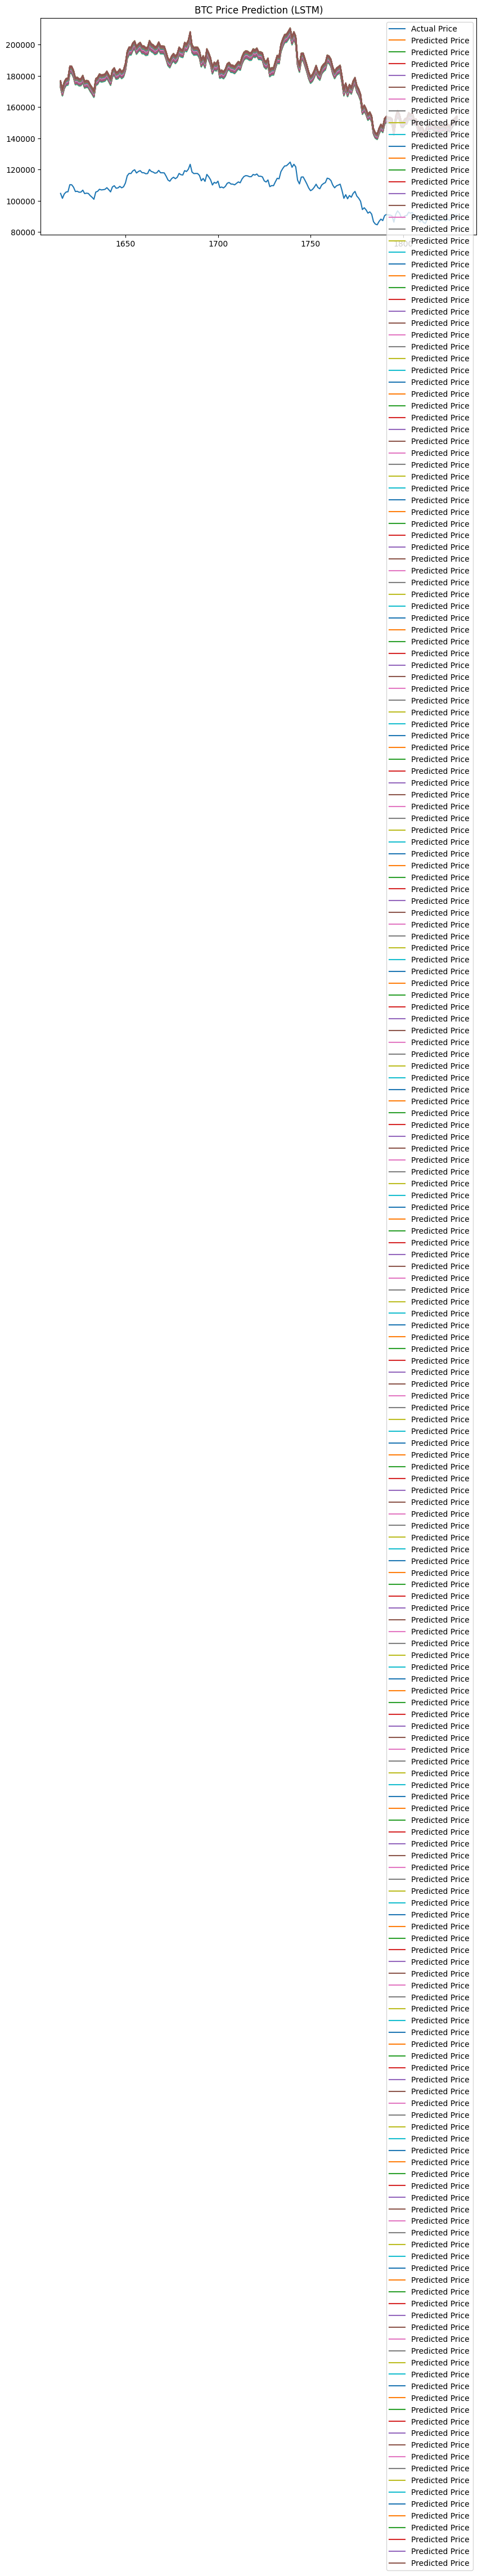

In [14]:
plt.figure(figsize=(10,5))
plt.plot(test_df.index[TIME_STEPS:], test_df['Close'].values[TIME_STEPS:], label='Actual Price')
plt.plot(test_df.index[TIME_STEPS:], pred_prices, label='Predicted Price')
plt.legend()
plt.title("BTC Price Prediction (LSTM)")
plt.show()


In [15]:
last_sequence = test_scaled[-TIME_STEPS:]
last_sequence = last_sequence.reshape(1, TIME_STEPS, FEATURES)

predicted_return = model.predict(last_sequence)[0][0]
today_price = df['Close'].iloc[-1]

tomorrow_price = today_price * np.exp(predicted_return)

print("Today BTC Price:", today_price)
print("Predicted Tomorrow BTC Price:", tomorrow_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Today BTC Price: Ticker
BTC-USD    91295.414062
Name: 1829, dtype: float64
Predicted Tomorrow BTC Price: Ticker
BTC-USD    153802.925568
Name: 1829, dtype: float64


In [ ]:
x, y = np.array(x), np.array(y)

In [ ]:
x = np.reshape(x,(x.shape[0],x.shape[1])) 

In [ ]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences=True, input_shape=(x.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu',return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x, y, epochs=1, verbose=1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 205ms/step - loss: 0.0388


In [ ]:
test_data = pd.concat((train_data.tail(100), test_data), ignore_index=True)

In [ ]:
test_data

Price,Close
Ticker,BTC-USD
0,104883.328125
1,104684.289062
2,103309.601562
3,102257.406250
4,100987.140625
...,...
195,88430.132812
196,87508.828125
197,88731.984375


In [ ]:
test_data_scale = scaler.transform(test_data)

In [ ]:
x = []
y = []

for i in range(base_days, test_data.shape[0]):
    x.append(test_data_scale[i-base_days:i])
    y.append(test_data_scale[i,0])

In [ ]:
x,y = np.array(x), np.array(y)

In [ ]:
x = np.reshape(x,(x.shape[0],x.shape[1],1))

In [ ]:
pred = model.predict(x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step


In [ ]:
pred = scaler.inverse_transform(pred)

In [ ]:
pred

array([[107616.5  ],
       [107729.7  ],
       [107809.75 ],
       [107855.2  ],
       [107870.6  ],
       [107862.28 ],
       [107843.2  ],
       [107829.51 ],
       [107838.164],
       [107883.71 ],
       [107978.305],
       [108131.78 ],
       [108345.47 ],
       [108618.84 ],
       [108946.31 ],
       [109308.18 ],
       [109678.98 ],
       [110039.84 ],
       [110376.3  ],
       [110675.234],
       [110923.93 ],
       [111109.4  ],
       [111219.67 ],
       [111247.74 ],
       [111192.914],
       [111061.57 ],
       [110860.62 ],
       [110597.445],
       [110283.266],
       [109931.44 ],
       [109555.96 ],
       [109173.695],
       [108799.64 ],
       [108444.734],
       [108112.875],
       [107802.37 ],
       [107511.09 ],
       [107237.11 ],
       [106979.43 ],
       [106732.14 ],
       [106482.5  ],
       [106220.83 ],
       [105936.586],
       [105624.43 ],
       [105281.04 ],
       [104908.875],
       [104514.64 ],
       [10410

In [ ]:
#FUTURE PRICE OF BTC

In [ ]:
m = y
z= []
future_days = 1
for i in range(base_days, len(m)+future_days):
    m = m.reshape(-1,1)
    inter = [m[-base_days:,0]]
    inter = np.array(inter)
    inter = np.reshape(inter, (inter.shape[0], inter.shape[1],1))
    pred = model.predict(inter)
    m = np.append(m ,pred)
    z = np.append(z, pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [ ]:
z = np.array(z)
z = scaler.inverse_transform(z.reshape(-1,1))

In [ ]:
z

array([[81072.09384522]])

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import streamlit as st
#load Model 
model = load_model('C:\Z Drive\Data Science NED\BTC_PROJECT\BTC_PRICE_PREDICTION_Model.keras')

st.header('Bitcoin Price Prediction Model')
st.subheader('Bitcoin Price Data')
data = pd.DataFrame(yf.download('BTC-USD','2024-01-01','2026-01-06'))
data = data.reset_index()
st.write(data)
data.columns

In [3]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2024-01-01,44167.332031,44175.437500,42214.976562,42280.234375,18426978443
1,2024-01-02,44957.968750,45899.707031,44176.949219,44187.140625,39335274536
2,2024-01-03,42848.175781,45503.242188,40813.535156,44961.601562,46342323118
3,2024-01-04,44179.921875,44770.023438,42675.175781,42855.816406,30448091210
4,2024-01-05,44162.691406,44353.285156,42784.718750,44192.980469,32336029347
...,...,...,...,...,...,...
731,2026-01-01,88731.984375,88803.226562,87399.406250,87508.046875,18849043990
732,2026-01-02,89944.695312,90884.460938,88298.617188,88733.062500,46398906171
733,2026-01-03,90603.187500,90679.570312,89328.070312,89945.054688,20774828592


In [ ]:
data.drop(columns = ['Date','High','Low','Open','Volume'], inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19376\73263344.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop(columns = ['Date','High','Low','Open','Volume'], inplace=True)


In [5]:
data


Price,Close
Ticker,BTC-USD
0,44167.332031
1,44957.968750
2,42848.175781
3,44179.921875
4,44162.691406
...,...
731,88731.984375
732,89944.695312
733,90603.187500


In [ ]:
data = yf.download("BTC-USD", start="2021-01-01", end="2026-01-06")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = pd.DataFrame(data)
data 

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2021-01-01,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782
...,...,...,...,...,...
2025-12-31,87508.828125,89080.289062,87130.562500,88429.585938,33830210616
2026-01-01,88731.984375,88803.226562,87399.406250,87508.046875,18849043990


In [ ]:
data.reset_index(inplace=True)
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2021-01-01,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
1,2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2,2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
3,2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
4,2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782
...,...,...,...,...,...,...
1824,2025-12-30,88430.132812,89297.937500,86735.546875,87134.351562,35586356225
1825,2025-12-31,87508.828125,89080.289062,87130.562500,88429.585938,33830210616
1826,2026-01-01,88731.984375,88803.226562,87399.406250,87508.046875,18849043990


In [ ]:
# data.drop(columns=['Price Ticker'], inplace=True)
data.drop(columns = ['Date','Open','High','Low','Volume'], inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_15340\2672140533.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data.drop(columns = ['Date','Open','High','Low','Volume'], inplace=True)


In [ ]:
data

Price,Close
Ticker,BTC-USD
0,29374.152344
1,32127.267578
2,32782.023438
3,31971.914062
4,33992.429688
...,...
1824,88430.132812
1825,87508.828125
1826,88731.984375


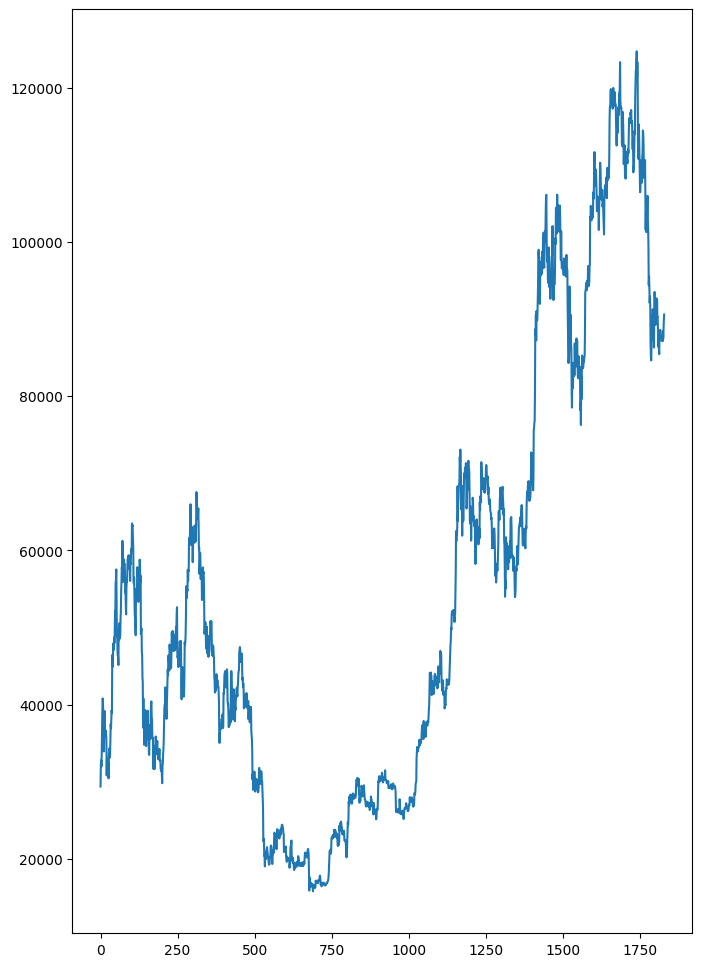

In [ ]:
plt.figure(figsize=(8,12))
plt.plot(data)
plt.show()

In [ ]:
train_data = data[:-100]
test_data = data[-100:]

In [ ]:
train_data.shape

(1729, 1)

In [ ]:
test_data.shape

(100, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
train_data_scale = scaler.fit_transform(train_data)

In [ ]:
base_days = 100

In [ ]:
x = []
y = []
for i in range(base_days,train_data_scale.shape[0]):
    x.append(train_data_scale[i-base_days:i])
    y.append(train_data_scale[i,0])
    

In [ ]:
x, y = np.array(x), np.array(y)

In [ ]:
x = np.reshape(x,(x.shape[0],x.shape[1])) 

In [ ]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences=True, input_shape=(x.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu',return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x, y, epochs=1, verbose=1)

51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 205ms/step - loss: 0.0388


In [ ]:
test_data = pd.concat((train_data.tail(100), test_data), ignore_index=True)

In [ ]:
test_data

Price,Close
Ticker,BTC-USD
0,104883.328125
1,104684.289062
2,103309.601562
3,102257.406250
4,100987.140625
...,...
195,88430.132812
196,87508.828125
197,88731.984375


In [ ]:
test_data_scale = scaler.transform(test_data)

In [ ]:
x = []
y = []

for i in range(base_days, test_data.shape[0]):
    x.append(test_data_scale[i-base_days:i])
    y.append(test_data_scale[i,0])

In [ ]:
x,y = np.array(x), np.array(y)

In [ ]:
x = np.reshape(x,(x.shape[0],x.shape[1],1))

In [ ]:
pred = model.predict(x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step


In [ ]:
pred = scaler.inverse_transform(pred)

In [ ]:
pred

array([[107616.5  ],
       [107729.7  ],
       [107809.75 ],
       [107855.2  ],
       [107870.6  ],
       [107862.28 ],
       [107843.2  ],
       [107829.51 ],
       [107838.164],
       [107883.71 ],
       [107978.305],
       [108131.78 ],
       [108345.47 ],
       [108618.84 ],
       [108946.31 ],
       [109308.18 ],
       [109678.98 ],
       [110039.84 ],
       [110376.3  ],
       [110675.234],
       [110923.93 ],
       [111109.4  ],
       [111219.67 ],
       [111247.74 ],
       [111192.914],
       [111061.57 ],
       [110860.62 ],
       [110597.445],
       [110283.266],
       [109931.44 ],
       [109555.96 ],
       [109173.695],
       [108799.64 ],
       [108444.734],
       [108112.875],
       [107802.37 ],
       [107511.09 ],
       [107237.11 ],
       [106979.43 ],
       [106732.14 ],
       [106482.5  ],
       [106220.83 ],
       [105936.586],
       [105624.43 ],
       [105281.04 ],
       [104908.875],
       [104514.64 ],
       [10410

In [ ]:
#FUTURE PRICE OF BTC

In [ ]:
m = y
z= []
future_days = 1
for i in range(base_days, len(m)+future_days):
    m = m.reshape(-1,1)
    inter = [m[-base_days:,0]]
    inter = np.array(inter)
    inter = np.reshape(inter, (inter.shape[0], inter.shape[1],1))
    pred = model.predict(inter)
    m = np.append(m ,pred)
    z = np.append(z, pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [ ]:
z = np.array(z)
z = scaler.inverse_transform(z.reshape(-1,1))

In [ ]:
z

array([[81072.09384522]])